In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Netflix Stock Price Prediction

For this project, I will be using the historical stock price data of Netflix ([NFLX](https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction)) to predict the future stock prices. The dataset contains the following columns:

- Date: The date of the stock price
- Open: The opening price of the stock
- High: The highest price of the stock
- Low: The lowest price of the stock
- Close: The closing price of the stock
- Adj Close: The adjusted closing price of the stock
- Volume: The volume of the stock traded

For this dataset, it contains the historical stock price data of Netflix from 5th Feb 2018 to 5th Feb 2022 (5 Years).

I will be using the historical stock price data to predict the future stock prices using the XGBoost algorithm. I will split the data into training and testing data and then train the model on the training data. Finally, I will evaluate the model on the testing data to see how well it performs.

This project **SHOULD NOT** be used for actual trading purposes. The stock market is highly volatile and too complex to predict accurately.

In [226]:
df = pd.read_csv('NFLX.csv')
df.Date = pd.to_datetime(df.Date)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [227]:
# Check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [228]:
# Making a target column to be used to predict. Basically, the next day closing price.
df["Target"] = df.Close.shift(-1)
df.dropna(inplace=True)

In [229]:
# Splitting the time series data into train and test data
def train_test_split(data, perc):
    n = int(len(data) * (1 - perc))
    return data.iloc[:n], data.iloc[n:]

train, test = train_test_split(df, 0.2)

In [230]:
# Scaling the data
import warnings
warnings.filterwarnings('ignore')
scaler = StandardScaler()
columns_to_scale = ['High', 'Low', 'Volume']
train.loc[:, columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
test.loc[:, columns_to_scale] = scaler.transform(test[columns_to_scale])
warnings.filterwarnings('default')

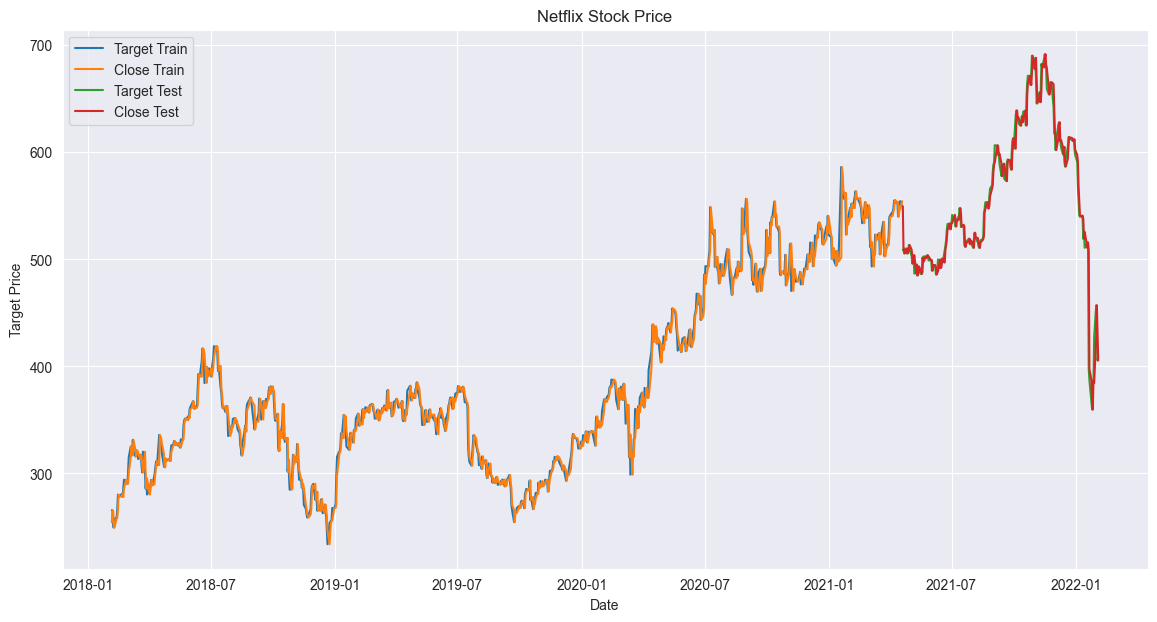

In [231]:
plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Target'], label='Target Train')
plt.plot(train['Date'], train['Close'], label='Close Train')
plt.plot(test['Date'], test['Target'], label='Target Test')
plt.plot(test['Date'], test['Close'], label='Close Test')
plt.title('Netflix Stock Price')
plt.xlabel('Date')
plt.ylabel('Target Price')
plt.legend()
plt.show()

# Feature Engineering / Creation

Since the dataset only contains the historical stock price data, I will create some additional features that might help the model to predict the future stock prices.

I will create the following features:

- Day of the week
- Month
- Quarter
- Year
- Day of the Year
- MA (Moving Average) - Smoothing the data / Filtering the noise
- RSI (Relative Strength Index) - Measure the stock momentum (The speed and size of price changes)
- MACD (Moving Average Convergence Divergence) - Indicator of the strength and direction of a trend
- Lag features (Close, Volume, Low, High) - How the stock price might be affected by the previous days' stock prices
- Signal Line - Strength, Direction, Momentum, and Duration of a trend in stock prices.

For this part, we are trying to find a good set of lags for our model. This means that the resulting differences between the lag value should be stationary. This is because the mean and the variance is stable and it makes predictability easier. We will be using the Augmented Dickey-Fuller test to check for stationarity.

We will also be plotting the ACF and PACF to find a good set of moving averages for our model. This will help us reduce the white noise in the time series data.

In [232]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def check_stationary_lags(series, lags):
    for lag in lags:
        print(f'Lag: {lag}')
        check_stationarity(series.diff(lag).dropna())

check_stationary_lags(train['Close'], [1, 5, 10, 20, 50, 75, 100])

Lag: 1
ADF Statistic: -13.023971
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary
Lag: 5
ADF Statistic: -5.732167
p-value: 0.000001
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary
Lag: 10
ADF Statistic: -5.240978
p-value: 0.000007
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary
Lag: 20
ADF Statistic: -4.501378
p-value: 0.000196
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary
Lag: 50
ADF Statistic: -3.341824
p-value: 0.013109
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary
Lag: 75
ADF Statistic: -2.690610
p-value: 0.075677
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Non-stationary
Lag: 100
ADF Statistic: -2.368287
p-value: 0.150888
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Non-stationary


We can see that the following lags are stationary:
- Lag: 1
- Lag: 5
- Lag: 10
- Lag: 20
- Lag: 50

We will be using these lags for our model and test which one will be useful for our model.

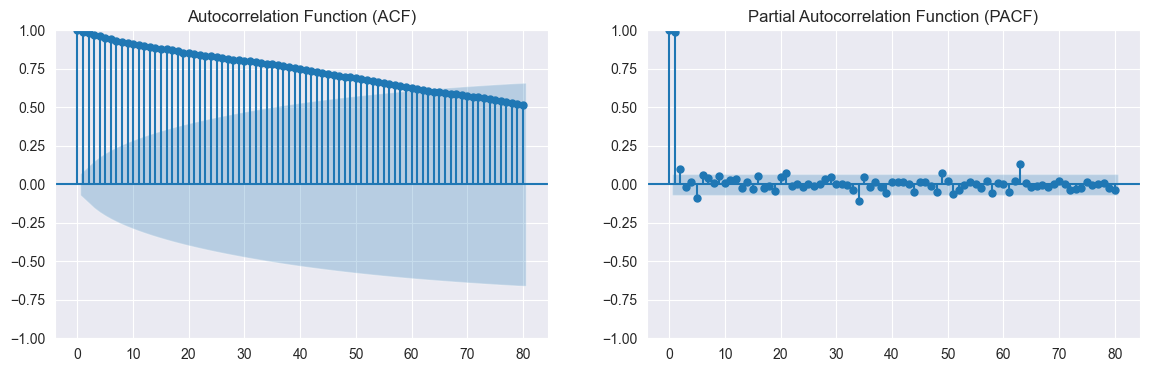

In [233]:
def plot_acf_pacf(series, lags):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(series, lags=lags, ax=ax1)
    ax1.set_title('Autocorrelation Function (ACF)')
    plot_pacf(series, lags=lags, ax=ax2)
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    plt.show()
    
plot_acf_pacf(train['Close'], 80)

From our ACF Plot, we can see that at around lag 60-65, the ACF plot starts to drop. This means that we can use MA of 60, 65 for our model.

Now that we have found a good set of lags and moving averages, we will create the features for our model.
We are creating many features will be picking the best one later on. This is because we want to test which features are the best for our model.

In [234]:
# Creating time series features based on time series date data.
def create_features(df):
    df = df.copy()
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['day_of_month'] = df['Date'].dt.day
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year
    df['day_of_year'] = df['Date'].dt.dayofyear
    
    for lag in [1, 5, 10, 20, 50]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'Volume_lag_{lag}'] = df['Volume'].shift(lag)
        df[f'Low_lag_{lag}'] = df['Low'].shift(lag)
        df[f'High_lag_{lag}'] = df['High'].shift(lag)
        df[f'Open_lag_{lag}'] = df['Open'].shift(lag)
        df[f'Adj_Close_lag_{lag}'] = df['Adj Close'].shift(lag)
    
    df['Price_Range'] = df['High'] - df['Low']
    df['Pct_Change'] = (df['High'] - df['Low'])/df['Low'] * 100
    # Calculate moving averages (MA) for different windows
    for window in [60, 65, 70]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
    
    # Calculate Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Calculate MACD (Moving Average Convergence Divergence)
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

df = create_features(df)
train = create_features(train)
test = create_features(test)

# Create our Model(s)

Let's create a basic model first. We are doing this to find a good set of features within our many features. We will also be using this basic model as a comparison later on with another model to see whether feature selection and hyperparameter tuning helps with our forecasting or not.

In [235]:
target = 'Target'
features = [col for col in df.columns if col not in ['Date', 'Target']]
print(features)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'day_of_week', 'month', 'day_of_month', 'quarter', 'year', 'day_of_year', 'Close_lag_1', 'Volume_lag_1', 'Low_lag_1', 'High_lag_1', 'Open_lag_1', 'Adj_Close_lag_1', 'Close_lag_5', 'Volume_lag_5', 'Low_lag_5', 'High_lag_5', 'Open_lag_5', 'Adj_Close_lag_5', 'Close_lag_10', 'Volume_lag_10', 'Low_lag_10', 'High_lag_10', 'Open_lag_10', 'Adj_Close_lag_10', 'Close_lag_20', 'Volume_lag_20', 'Low_lag_20', 'High_lag_20', 'Open_lag_20', 'Adj_Close_lag_20', 'Close_lag_50', 'Volume_lag_50', 'Low_lag_50', 'High_lag_50', 'Open_lag_50', 'Adj_Close_lag_50', 'Price_Range', 'Pct_Change', 'MA_60', 'MA_65', 'MA_70', 'RSI', 'MACD', 'Signal_Line']


In [236]:
reg = XGBRegressor(n_estimators=1000, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:85.07035	validation_1-rmse:185.60388
[100]	validation_0-rmse:32.82479	validation_1-rmse:102.34024
[200]	validation_0-rmse:13.93099	validation_1-rmse:79.38950
[300]	validation_0-rmse:7.08814	validation_1-rmse:73.75649
[400]	validation_0-rmse:4.54241	validation_1-rmse:71.53172
[500]	validation_0-rmse:3.37779	validation_1-rmse:71.25690
[600]	validation_0-rmse:2.69926	validation_1-rmse:70.94444
[700]	validation_0-rmse:2.34047	validation_1-rmse:70.97940
[800]	validation_0-rmse:2.03223	validation_1-rmse:71.06290
[900]	validation_0-rmse:1.84037	validation_1-rmse:70.97031
[999]	validation_0-rmse:1.66700	validation_1-rmse:70.88884


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

Here, we will plot to see which features play have the most roles in the model. This information will be used to build a better model later on.


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:1273: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


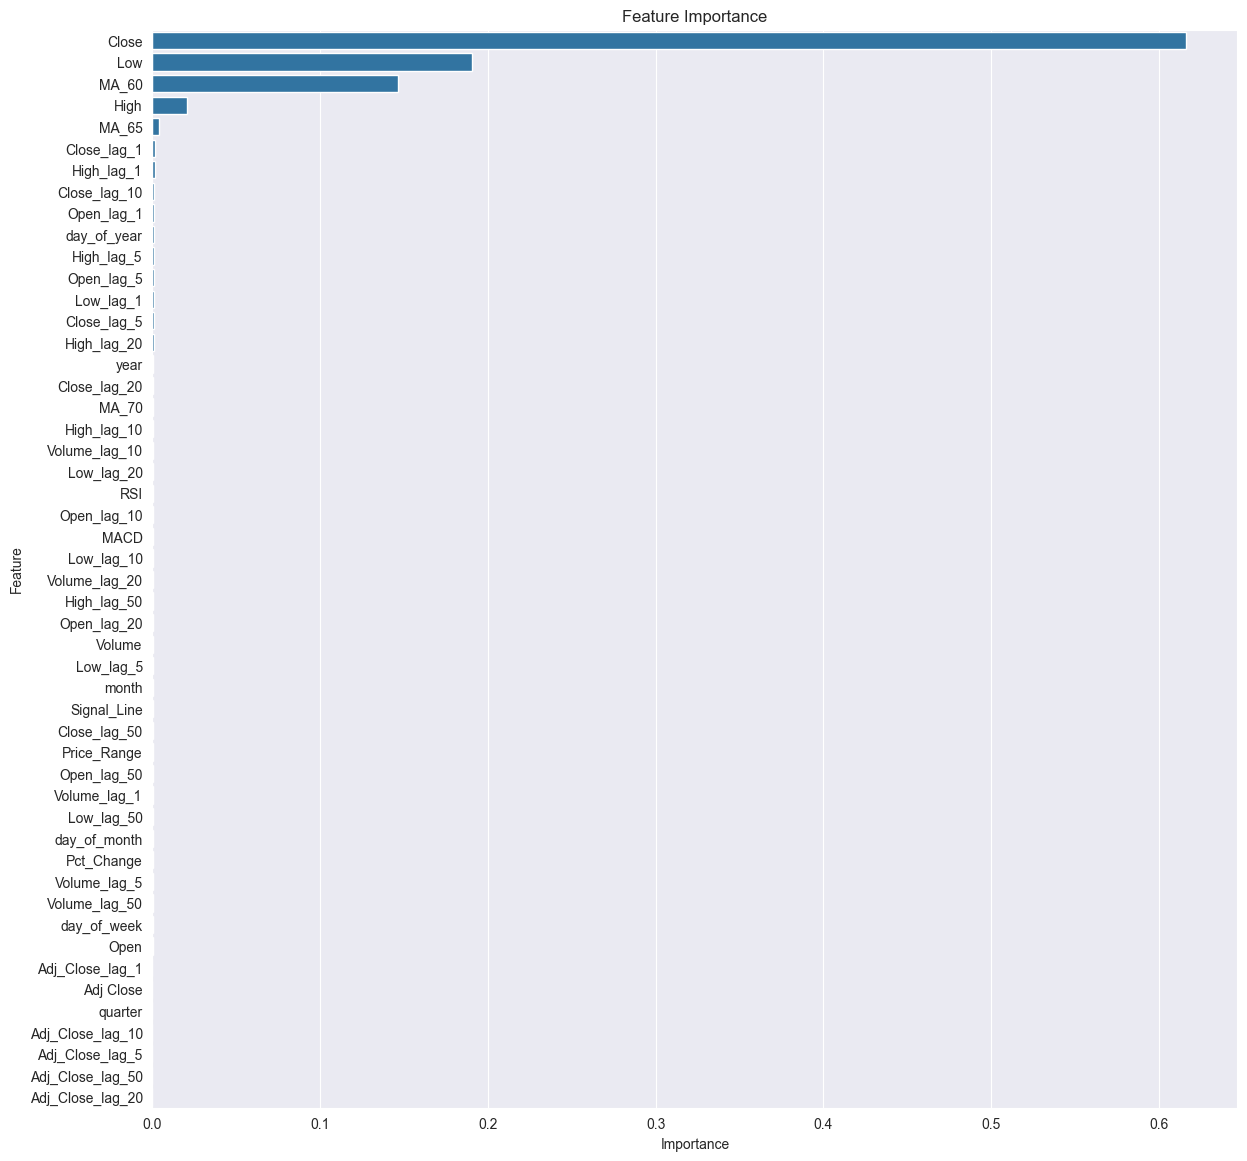

In [237]:
def plot_feature_importance(model):
    feature_names = model.get_booster().feature_names
    feature_importances = model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(14, 14))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df,
                estimator=np.mean)
    plt.title('Feature Importance')
    plt.show()
plot_feature_importance(reg)

Interestingly, there are many useless features within the model. We will be creating another model soon with only the important features.


These are the 3 most important features:
- Close
- Low
- MA_60

A good way to improve the model is to test by removing the features and cross-validate the model to see which combination of features is the best for the model.

Good news: Sklearn has a built-in function for this called RFECV (Recursive Feature Elimination with Cross-Validation).

Bad news: It is computationally expensive and will take a long time to run.

Optimal number of features: 2
Feature ranking: [40  3  1  1 49 27 41 30 36 48 42  6 13 29 11 10 22 47  7 38 31 18 15 44
  5  8 32 16 23 46  9 21 14 12 17 45 28 37 35 19 25 43 20 34  2  4 39 24
 33 26]


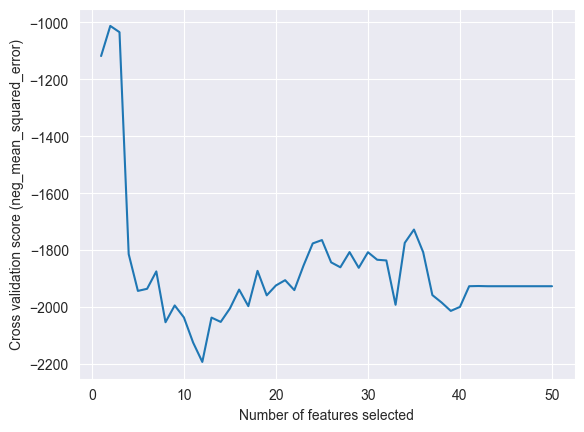

In [238]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

estimator = XGBRegressor()
selector = RFECV(estimator=estimator, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)
print("Optimal number of features:", selector.n_features_)
print("Feature ranking:", selector.ranking_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.show()

In [239]:
indices_of_top_features = np.where(selector.ranking_ == 1)[0][:selector.n_features_]
top_features = [X_train.columns[idx] for idx in indices_of_top_features]
print(top_features)

['Low', 'Close']


From the result, we can see that the optimal number of features is 2. The features are:
- Close
- Low

We will be using these features to create a new model and compare the result with the previous model.

# Forecasting the stock prices

We will test our garbage model with all the features as a baseline to forecast the stock price. Later on, we will try to do the same with a better model.

After we have created a new model, we will do a cross-validation on both the models to see the average MSE to see which model is better at predicting the stock.

In [240]:
test['prediction'] = reg.predict(X_test)
train['prediction'] = reg.predict(X_train)
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.merge(train[['prediction']], how='left', left_index=True, right_index=True)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,day_of_week,month,...,Adj_Close_lag_50,Price_Range,Pct_Change,MA_60,MA_65,MA_70,RSI,MACD,Signal_Line,prediction
0,2018-02-05,262.000000,-1.408046,-1.503808,254.259995,254.259995,11896100,265.720001,0,2,...,NaN,0.095762,-6.367982,NaN,NaN,NaN,NaN,0.000000,0.000000,265.595551
1,2018-02-06,247.699997,-1.421856,-1.563138,265.720001,265.720001,12595800,264.559998,1,2,...,NaN,0.141282,-9.038340,NaN,NaN,NaN,NaN,0.914189,0.182838,264.084412
2,2018-02-07,266.579987,-1.355680,-1.335136,264.559998,264.559998,8981500,250.100006,2,2,...,NaN,-0.020544,1.538686,NaN,NaN,NaN,NaN,1.527479,0.451766,251.355591
3,2018-02-08,267.079987,-1.411268,-1.504162,250.100006,250.100006,9306700,249.470001,3,2,...,NaN,0.092894,-6.175769,NaN,NaN,NaN,NaN,0.837067,0.528826,250.748306
4,2018-02-09,253.850006,-1.547305,-1.667998,249.470001,249.470001,16906900,257.950012,4,2,...,NaN,0.120693,-7.235806,NaN,NaN,NaN,NaN,0.236349,0.470331,257.363647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-01-28,386.760010,-0.037321,-0.064197,384.359985,384.359985,11966600,427.140015,4,1,...,687.400024,0.026876,-41.864937,589.595000,596.336461,600.644713,16.769880,-59.233806,-46.037788,NaN
1004,2022-01-31,401.970001,0.431097,0.243895,427.140015,427.140015,20047500,457.130005,0,1,...,691.690002,0.187201,76.754601,585.242501,592.709076,597.816142,29.680923,-55.671327,-47.964496,NaN
1005,2022-02-01,432.959991,0.785344,0.566378,457.130005,457.130005,22542300,429.480011,1,2,...,682.020020,0.218966,38.660846,581.721334,589.371846,595.015714,36.337520,-49.853416,-48.342280,NaN
1006,2022-02-02,448.250000,0.710536,0.577465,429.480011,429.480011,14346000,405.600006,2,2,...,678.799988,0.133070,23.043845,578.117334,585.359077,591.654285,33.694538,-46.932791,-48.060382,NaN


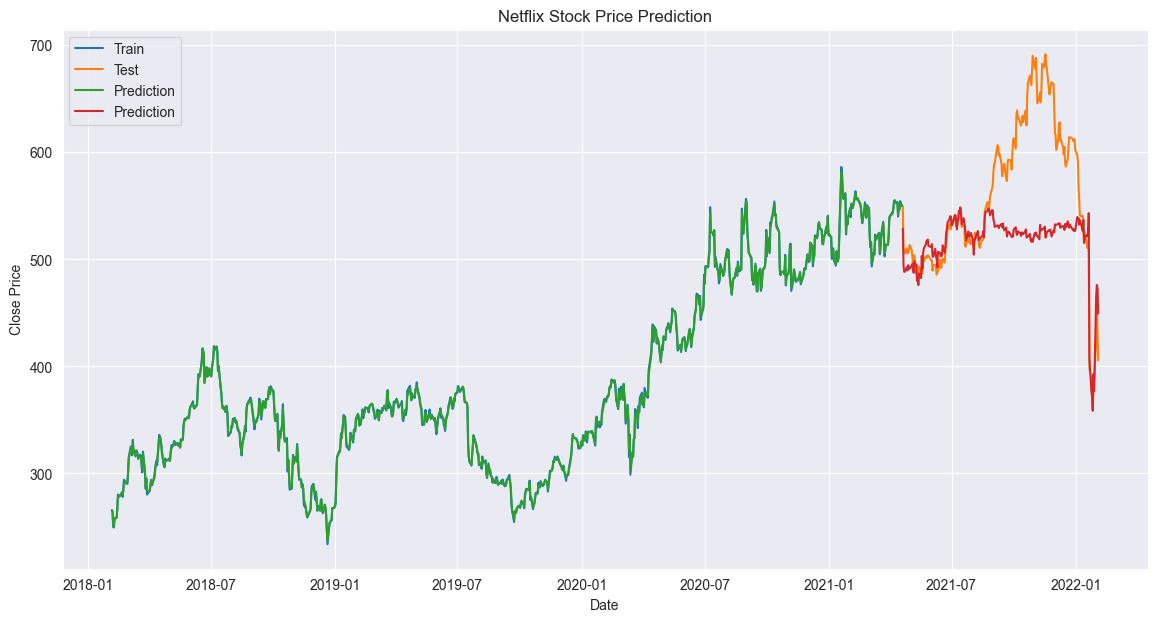

In [241]:
plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Target'], label='Train')
plt.plot(test['Date'], test['Close'], label='Test')
plt.plot(train['Date'], train['prediction'], label='Prediction')
plt.plot(test['Date'], test['prediction'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Netflix Stock Price Prediction')
plt.legend()
plt.show()

# Improving the Model
The model seems to predict the stock prices for some time periods but fails to predict the stock prices for some time periods. Let's try to improve the model by using only the important features that we have found earlier.

Typically, we would want to adjust the hyperparameters together with feature selection at the same time. However, for this project, I will only do feature selection and perform hyperparameter tuning separately. This is because finding the best combination of hyperparameters and features can be computationally expensive.

Choosing good features over micro-optimizing hyperparameters is generally more important.

I'll be saving the best hyperparameter obtained from GridSearchCV as it generally takes too long to run the GridSearchCV again.

Here we will try to pick these features and test the robustness of the model with cross-validation. We will then compare the result with the previous model.

In [242]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

X = df[[col for col in df.columns if col not in ['Date', 'Target']]]
y = df['Target'].dropna()

mse_lst = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reg = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_lst.append(mse)
    
print(f'Mean Squared Error: {np.mean(mse_lst)}')

Mean Squared Error: 2264.5273281347595


In [243]:
tscv = TimeSeriesSplit(n_splits=5)

X = df[['Low', 'Close']].dropna()
y = df['Target'].dropna()

mse_lst = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reg2 = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    reg2.fit(X_train, y_train)

    y_pred = reg2.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_lst.append(mse)
    
print(f'Mean Squared Error: {np.mean(mse_lst)}')

Mean Squared Error: 1381.4837351592714


From the result, we can clearly see that the model with only the important features is much better at predicting the stock prices than the model with all the features.

# Hyperparameter Tuning

Now that we have found a good set of features, we will try to find the best hyperparameters for our model. We will be using GridSearchCV to find the best hyperparameters for our model. We will be using the same features as before.

In [244]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
#     'min_child_weight': [1, 2, 3, 4, 5],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1]
# }
# 
# reg2 = XGBRegressor()
# grid_search = GridSearchCV(reg2, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)
# print(grid_search.best_params_)

This took a long time to run. We will be saving the model for future use.
The best hyperparameters for our model are:

{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}

Let's test the model with the best hyperparameters and see how well it performs.

In [245]:
tscv = TimeSeriesSplit(n_splits=5)

X = df[['Low', 'Close']].dropna()
y = df['Target'].dropna()

mse_lst = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_mdl = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.05, min_child_weight=1, subsample=0.6)
    best_mdl.fit(X_train, y_train)

    y_pred = best_mdl.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_lst.append(mse)

print(f'Mean Squared Error: {np.mean(mse_lst)}')

Mean Squared Error: 1343.9823686799518


The performance of our model has minimally improved after hyperparameter tuning.

# Plotting the result


In [246]:
test['prediction'] = best_mdl.predict(test[['Low', 'Close']])
train['prediction'] = best_mdl.predict(train[['Low', 'Close']])
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.merge(train[['prediction']], how='left', left_index=True, right_index=True)

,Date,Open,High,Low,Close,Adj Close,Volume,Target,day_of_week,month,...,Adj_Close_lag_50,Price_Range,Pct_Change,MA_60,MA_65,MA_70,RSI,MACD,Signal_Line,prediction
0,2018-02-05,262.000000,-1.408046,-1.503808,254.259995,254.259995,11896100,265.720001,0,2,...,NaN,0.095762,-6.367982,NaN,NaN,NaN,NaN,0.000000,0.000000,261.637878
1,2018-02-06,247.699997,-1.421856,-1.563138,265.720001,265.720001,12595800,264.559998,1,2,...,NaN,0.141282,-9.038340,NaN,NaN,NaN,NaN,0.914189,0.182838,263.827332
2,2018-02-07,266.579987,-1.355680,-1.335136,264.559998,264.559998,8981500,250.100006,2,2,...,NaN,-0.020544,1.538686,NaN,NaN,NaN,NaN,1.527479,0.451766,260.912964
3,2018-02-08,267.079987,-1.411268,-1.504162,250.100006,250.100006,9306700,249.470001,3,2,...,NaN,0.092894,-6.175769,NaN,NaN,NaN,NaN,0.837067,0.528826,250.741486
4,2018-02-09,253.850006,-1.547305,-1.667998,249.470001,249.470001,16906900,257.950012,4,2,...,NaN,0.120693,-7.235806,NaN,NaN,NaN,NaN,0.236349,0.470331,251.477905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-01-28,386.760010,-0.037321,-0.064197,384.359985,384.359985,11966600,427.140015,4,1,...,687.400024,0.026876,-41.864937,589.595000,596.336461,600.644713,16.769880,-59.233806,-46.037788,NaN
1004,2022-01-31,401.970001,0.431097,0.243895,427.140015,427.140015,20047500,457.130005,0,1,...,691.690002,0.187201,76.754601,585.242501,592.709076,597.816142,29.680923,-55.671327,-47.964496,NaN
1005,2022-02-01,432.959991,0.785344,0.566378,457.130005,457.130005,22542300,429.480011,1,2,...,682.020020,0.218966,38.660846,581.721334,589.371846,595.015714,36.337520,-49.853416,-48.342280,NaN
1006,2022-02-02,448.250000,0.710536,0.577465,429.480011,429.480011,14346000,405.600006,2,2,...,678.799988,0.133070,23.043845,578.117334,585.359077,591.654285,33.694538,-46.932791,-48.060382,NaN


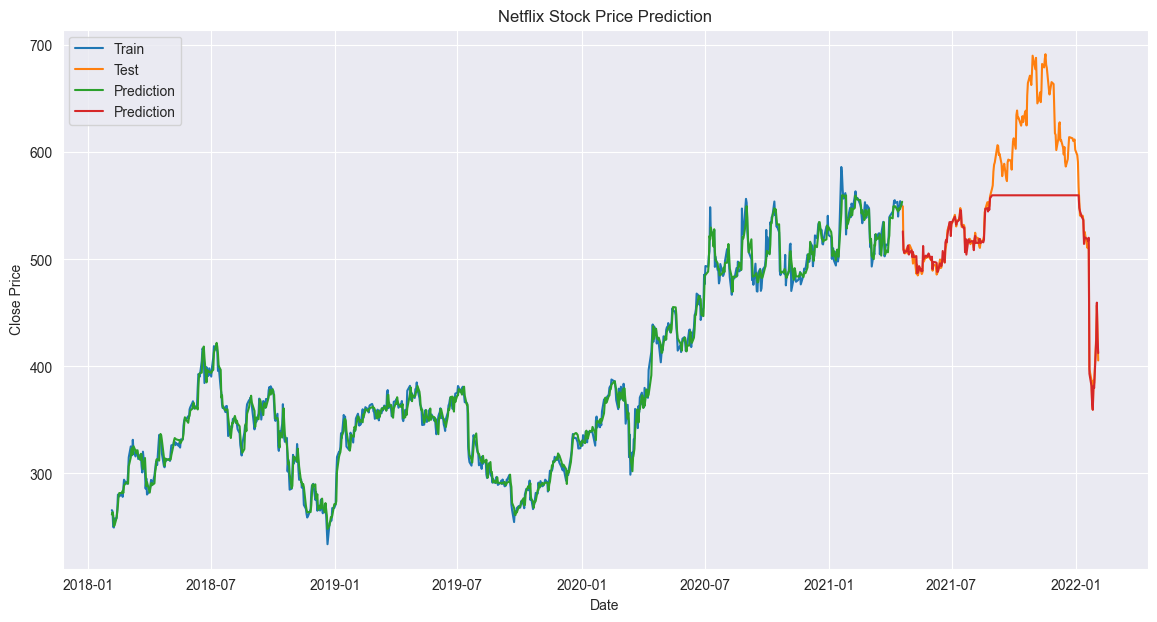

In [247]:
plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Target'], label='Train')
plt.plot(test['Date'], test['Close'], label='Test')
plt.plot(train['Date'], train['prediction'], label='Prediction')
plt.plot(test['Date'], test['prediction'], label='Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Netflix Stock Price Prediction')
plt.legend()
plt.show()

# Conclusion

In this project, we used the historical stock price data of Netflix to forecast the future stock prices. 

We used the XGBoost algorithm to predict the stock prices. We created 3 models:

1. A model with all the features
2. A model with only the important features
3. Model 2 with the best hyperparameters

We performed feature engineering to create new features, and feature selection to find the best features for our model. 
After that, we performed hyperparameter tuning to find the best hyperparameters for our model. The resulting model forecasted the stock prices accurately for some time periods but failed to predict the stock prices for some time periods. This can be seen from the graph above. 

Even without performing cross-validation, we would know that the model would perform horribly (inaccurately) since the only two features in our model are the 'Low' and 'Close' prices. If the model were to predict accurately with only those features, then everyone would be rich by now.

XGBoost is not the best model to predict stock prices. The stock market is too complex and volatile to predict accurately. Further improvement can be done by using a better model like LSTM or finding more data to predict the stock prices. 

Any suggestion on improving the model is welcomed (I'm very interested in this). Thank you for reading this project.